## Apply PCA to gene dependencies

Principal component analysis (PCA) is a commonly-used dimensionality reduction method that finds components that explain orthogonal variation in the data in a descending fashion.

We apply it to GeneEffect scores here and save latent representations (PCA components) for downstream comparative analyses (to compare with BetaVAE).

In [1]:
import sys
import pathlib
import pandas as pd
import plotnine as gg
from sklearn.decomposition import PCA

sys.path.insert(0, "../0.data-download/scripts/")
from data_loader import load_train_test_data

In [2]:
data_directory = pathlib.Path("../0.data-download/data")
dependency_file = pathlib.Path(f"{data_directory}/CRISPRGeneEffect.csv")
gene_dict_file = pathlib.Path(f"{data_directory}/CRISPR_gene_dictionary.tsv")

output_dir = pathlib.Path("results")
pca_output_file = pathlib.Path(f"{output_dir}/pca_latent.csv.gz")
output_pca_weights_file = pathlib.Path(f"{output_dir}/PCA_weight_matrix_gsea.csv")

In [3]:
pca_components = 50

In [4]:
# Load gene dependency data
dependency_df = pd.read_csv(dependency_file)

print(dependency_df.shape)
dependency_df.head(3)

(1095, 17932)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000001,-0.102725,0.058595,0.058246,-0.041881,-0.088661,0.170335,-0.015254,-0.223691,0.218612,...,-0.084055,-0.084184,0.131495,0.238702,0.201712,-0.250381,0.045612,0.044154,0.146801,-0.473583
1,ACH-000004,0.008878,-0.077633,-0.099297,0.030120,-0.080334,-0.112404,0.298774,-0.125139,0.218675,...,-0.066673,-0.443145,0.183618,0.058936,0.108711,0.056322,-0.355712,0.135310,0.200408,-0.076150
2,ACH-000005,-0.117950,0.013989,0.164099,0.184570,-0.201766,-0.202198,0.207814,-0.089192,-0.082624,...,-0.151588,-0.402572,-0.073320,-0.114402,-0.009449,-0.198378,-0.135007,0.014708,-0.065341,-0.196296


In [5]:
# Load gene dictionary (with QC columns)
gene_dict_df = (
    pd.read_csv(gene_dict_file, sep="\t")
    .query("qc_pass")
    .reset_index(drop=True)
)
gene_dict_df.entrez_id = gene_dict_df.entrez_id.astype(str)

print(gene_dict_df.shape)
gene_dict_df.head(3)

(2768, 6)


,entrez_id,symbol_id,dependency_column,qc_pass_pan,qc_pass_other,qc_pass
0,8086,AAAS,AAAS (8086),True,True,True
1,14,AAMP,AAMP (14),True,True,True
2,16,AARS1,AARS1 (16),True,True,True


## Subset input data to common gene sets

In [6]:
# Recode column names to entrez ids
entrez_genes = [x[1].strip(")").strip() for x in dependency_df.iloc[:, 1:].columns.str.split("(")]

entrez_intersection = list(
    set(gene_dict_df.entrez_id).intersection(set(entrez_genes))
)

print(len(entrez_intersection))

gene_dict_df = gene_dict_df.set_index("entrez_id").reindex(entrez_intersection)
gene_dict_df.head(3)

2768


,symbol_id,dependency_column,qc_pass_pan,qc_pass_other,qc_pass
entrez_id,,,,,
9044,BTAF1,BTAF1 (9044),True,True,True
1743,DLST,DLST (1743),True,True,True
9570,GOSR2,GOSR2 (9570),True,True,True


In [7]:
# Subset dependencies to the genes that passed qc
dependency_df.columns = ["ModelID"] + entrez_genes

dependency_df = dependency_df.loc[:, ["ModelID"] + gene_dict_df.index.tolist()]
dependency_df.columns = ["ModelID"] + gene_dict_df.symbol_id.tolist()

dependency_df = dependency_df.dropna(axis="columns")

print(dependency_df.shape)
dependency_df.head()

(1095, 2733)


,ModelID,BTAF1,DLST,GOSR2,MORC2,LCE3B,ITGB1,RNMT,KIFC1,MDM4,...,ATP5PF,SEC16A,PSMF1,RTF1,XAB2,NDOR1,B4GALT7,RABGGTB,SGF29,MED21
0,ACH-000001,-0.858001,-0.248968,-1.436472,-0.273149,-0.049183,-0.279758,-0.823263,-0.338392,-0.209515,...,-0.632881,-1.038579,-0.001298,-1.191848,-2.347592,-0.417675,0.089520,-0.831223,-0.641389,-0.908091
1,ACH-000004,-0.043353,-0.737198,-0.892357,-0.072794,0.178048,0.052465,-1.529502,-0.019577,-0.171728,...,-0.135074,-0.480937,-0.751078,-0.511111,-2.355329,-0.529441,0.016007,-0.896460,-0.523431,-1.007557
2,ACH-000005,-0.220836,-0.722669,-1.114484,-0.547712,-0.038972,0.117858,-1.024875,-0.288096,-0.048148,...,-0.187395,-0.791138,-0.754758,-1.265523,-1.734267,-0.716994,-0.009845,-0.778901,-0.328407,-0.817454
3,ACH-000007,-0.439822,-0.316911,-0.603102,-0.307463,0.156806,0.032386,-0.833598,-0.102079,-0.837182,...,-0.485481,-0.627277,0.074023,-0.645819,-2.698061,-0.880133,-0.001938,-1.504499,-0.574775,-0.499040
4,ACH-000009,-0.544852,-0.339843,-0.855488,-0.114675,0.129159,-0.452970,-0.843976,-0.170329,-0.142405,...,-0.292076,-0.363851,-0.028859,-0.924606,-2.296380,-0.546085,-0.276753,-1.140734,-0.461445,-0.836692


# Perform PCA

In [8]:
pca = PCA(n_components=pca_components)
pca.fit(dependency_df.drop(columns=["ModelID"]))

PCA(n_components=50)

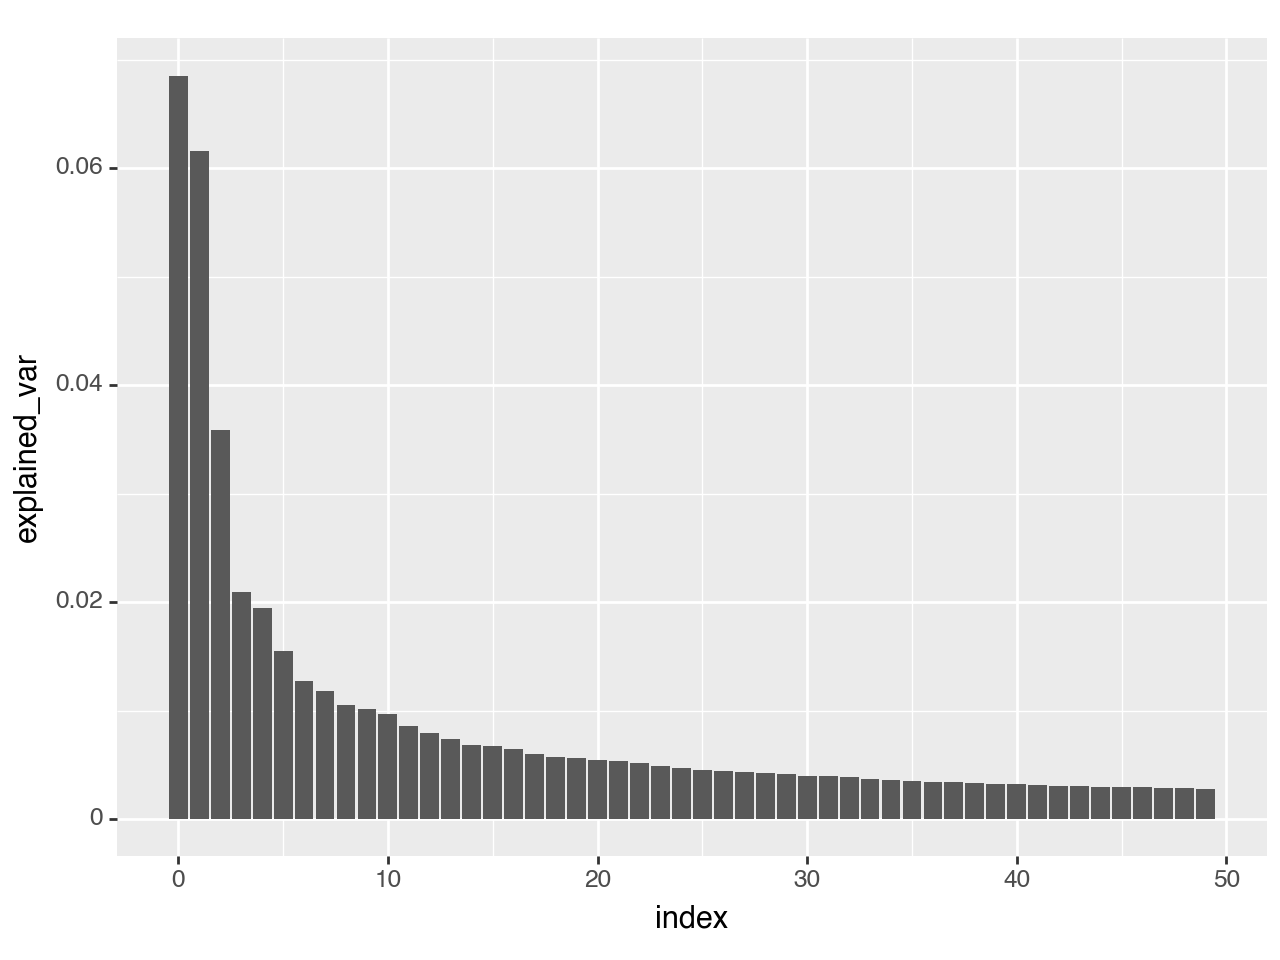

<Figure Size: (640 x 480)>

In [9]:
# Output explained variance and quickly visualize
explained_var = pd.DataFrame(pca.explained_variance_ratio_, columns=["explained_var"]).reset_index()

(
    gg.ggplot(explained_var, gg.aes(x="index", y="explained_var"))
    + gg.geom_bar(stat="identity")
)

In [10]:
# Transform models into pca space
dependency_df_transformed = pd.DataFrame(
    pca.transform(dependency_df.drop(columns=["ModelID"]))
)

# Recode column space and add back model IDs
dependency_df_transformed.columns = [f"PCA_{x}" for x in range(0, dependency_df_transformed.shape[1])]
dependency_df_transformed = pd.concat([dependency_df.loc[:, "ModelID"], dependency_df_transformed], axis="columns")

dependency_df_transformed.to_csv(pca_output_file, sep=",", index=False)

print(dependency_df_transformed.shape)
dependency_df_transformed.head(3)

(1095, 51)


,ModelID,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49
0,ACH-000001,-1.165179,3.085481,2.953869,4.612329,-1.540851,-1.627142,-1.246526,-0.514238,1.920790,...,1.292588,-0.287184,1.472160,-0.521439,-0.358502,-0.472181,0.715633,1.130877,-1.223945,-1.349819
1,ACH-000004,5.357760,1.083694,2.054472,-3.361544,0.905552,-2.288750,-1.482412,-1.229417,1.061960,...,0.287639,-0.740924,0.534463,-0.289841,-0.534976,1.298687,0.494270,-0.871420,0.346270,0.835674
2,ACH-000005,7.283533,4.596063,1.446880,-2.944721,1.755861,-4.092542,-1.750578,1.534036,0.170316,...,0.484863,0.142516,0.828304,-0.074323,-0.404984,0.702282,0.257154,-0.201336,0.997715,0.740591


In [11]:
# Obtain weights, which can be used in GSEA
pca_weights = pd.DataFrame(pca.components_, columns=dependency_df.drop(columns=["ModelID"]).columns.tolist()).transpose()
pca_weights.columns = [f"PCA_{x}" for x in range(0, pca_weights.shape[1])]

pca_weights = pca_weights.reset_index().rename(columns={"index": "genes"})

pca_weights.to_csv(output_pca_weights_file, index=False)

print(pca_weights.shape)
pca_weights.head(3)

(2732, 51)


,genes,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49
0,BTAF1,-0.003361,0.013265,-0.012563,0.004109,-0.009155,0.009965,-0.018731,0.002287,-0.032777,...,-0.014563,-0.009529,-0.024353,-0.009044,-0.015616,0.025229,0.028468,-0.023092,0.024621,-0.000486
1,DLST,-0.009585,0.032139,-0.037797,0.016934,-0.013620,-0.012536,0.012652,0.012191,-0.016073,...,0.003464,0.004938,-0.003392,-0.011788,-0.009208,-0.005858,0.006013,0.000975,-0.013812,-0.001327
2,GOSR2,0.033900,-0.012112,-0.015174,-0.020270,-0.008751,0.003576,0.013288,-0.018773,-0.012479,...,0.016345,0.008704,0.007671,-0.034701,0.018054,-0.016623,0.031513,-0.009309,0.013095,0.006297
